In [20]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import datasets, transforms, models

import PIL
from PIL import Image
import cv2

import csv
import pickle
import numpy as np
import textwrap

%matplotlib inline
import matplotlib.pyplot as plt

In [21]:
class TrafficSignsDataset(Dataset): # Klasa za opis skupa podataka.
    def __init__(self, path=None, transform=None):
        super().__init__()
        self.features = None # Skladiste podataka.
        self.labels = None # Skladiste labela.
        self.transform = transform # Transformacija, pretvaranje slike u tenzor.
        self._load(path) # Ucitavanje skupa podataka sa zadate putanje.
    
    def _load(self, path):
        with open(path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
    
    def __getitem__(self, index):
        # Ova metoda mora biti implementirana.
        # Predstavlja implementaciju preklapanja operatora indeksiranja.
        # Kao argument prima indeks, a kao povratnu vrijednost vraca podatak na zadatom indeksu.
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])
    
    def __len__(self):
        # Ova metoda mora biti implementirana.
        # Povratna vrijednost ove metode predstavlja ukupan broj pojava u skupu podataka.
        return len(self.features)

In [22]:
# Ucitavanje obucavajuceg skupa podataka. Definisanje transformacija, pretvaranje slike u tenzor.
train_dataset = TrafficSignsDataset("data/train.p", transform=transforms.ToTensor())
# Ucitavanje testnog skupa podataka. Definisanje transformacija, pretvaranje slike u tenzor.
test_dataset = TrafficSignsDataset("data/test.p", transform=transforms.ToTensor())

# Definisanje loader-a za obucavajuci skup podataka.
# Obucavanje ce biti vrseno nad skupovima od po 64 slike pri cemu ce izbor slika biti izmesan.
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64)
# Definisanje loader-a za testni skup podataka.
# Obucavanje ce biti vrseno nad skupovima od po 64 slike.
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

# Mapiranje numerickih vrijednosti na imena klasa.
index_label = {}
with open('./data/classes.csv') as f:
    f.readline() # Preskoci prvi red (zaglavlje).
    csv_data = csv.reader(f)
    for row in csv_data:
        if len(row) > 0:
            index_label[row[0]] = row[1]

In [23]:
training_examples = len(train_dataset) # Ukupan broj primjera za obucavanje.
testing_examples = len(test_dataset) # Ukupan broj primjera za testiranje.
training_examples_per_class = np.bincount(train_dataset.labels) # Broj primjera za obucavanje po klasi
testing_examples_per_class = np.bincount(test_dataset.labels) # Broj primjera za testiranje po klasi
image_shape = train_dataset.features[0].shape # Velicina (oblik) slike.
classes = len(set(train_dataset.labels)) # Ukupan broj klasa.

print(training_examples)
print(testing_examples)
print(image_shape)
print(classes)
print(np.bincount(train_dataset.labels))

34799
12630
(32, 32, 3)
43
[ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920
  690  540  360  990 1080  180  300  270  330  450  240 1350  540  210
  480  240  390  690  210  599  360 1080  330  180 1860  270  300  210
  210]


In [5]:
# Definisanje loader klase za izvrsavanje obucavanja i testiranja na dostupnom uredjaju (hardveru).
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [6]:
# Uredjaj (hardver) za izvrsavanje obucavanja i testiranja.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def to_device(x, y): # Izvrsavanje obucavanja i testiranja na dostupnom uredjaju (hardveru).
    return x.to(device), y.to(device, dtype=torch.int64)

# Definisanje loader-a za obucavajuci skup podataka.
# Izvrsavanje obucavanja na dostupnom uredjaju (hardveru).
train_loader = WrappedDataLoader(train_loader, to_device)
# Definisanje loader-a za testni skup podataka.
# Izvrsavanje testiranja na dostupnom uredjaju (hardveru).
test_loader = WrappedDataLoader(test_loader, to_device)

In [7]:
# Neuronska mreza.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Konvolutivni sloj neuronske mreze.
        # Broj ulaznih kanala je jednak broju kanala slike.
        # 6 izlaznih kanala, velicina filtera 5x5.
        self.conv1 = nn.Conv2d(image_shape[2], 6, 5)
        # Pooling sloj (sloj sjedinjavanja) neuronske mreze.
        # Velicina filtera 2x2.
        self.pool = nn.MaxPool2d(2, 2)
        # Konvolutivni sloj neuronske mreze.
        # Broj ulaznih kanala je jednak broju izlaznih kanala iz prethodnog konvolutivnog sloja.
        # 16 izlaznih kanala, velicina filtera 5x5.
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Prvi potpuno povezan sloj.
        # Broj ulaza je jednak broju izlaza iz prethodnog sloja (16 kanala * velicina filtera (5x5)).
        # Broj izlaza 120.
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # Drugi potpuno povezan sloj.
        # Broj ulaza je jednak broju izlaza iz prethodnog sloja.
        # Broj izlaza 84.
        self.fc2 = nn.Linear(120, 84)
        # Treci potpuno povezan sloj.
        # Broj ulaza je jednak broju izlaza iz prethodnog sloja.
        # Broj izlaza je jednak broju klasa.
        self.fc3 = nn.Linear(84, classes)

    def forward(self, x):
        # Definisanje forward pass-a.
        x = self.pool(F.relu(self.conv1(x))) # Prosledjivanje ulaza i racunanje izlaza prvog konvolutivnog sloja.
        x = self.pool(F.relu(self.conv2(x))) # Prosledjivanje ulaza i racunanje izlaza drugog konvolutivnog sloja.
        x = x.view(-1, 16 * 5 * 5) # Transformacija dobijenih slika u jednodimenzioni niz.
        # Racunanje rezultata prvog potpuno povezanog sloja.
        # Aktivaciona funkcija za ovaj sloj je ReLU6.
        x = F.relu(self.fc1(x))
        # Racunanje rezultata drugog potpuno povezanog sloja.
        # Aktivaciona funkcija za ovaj sloj je ReLU6.
        x = F.relu(self.fc2(x))
        # Racunanje konacnog izlaza iz neuronske mreze.
        x = self.fc3(x)
        # Vracanje vrijednosti dobijenog izlaza.
        return x

In [8]:
def train(net, criterion, optimizer, epochs): # Definisanje procesa obucavanja neuronske mreze.
    for epoch in range(epochs): # Proces obucavanja vrsi se u odgovarajucem broju epoha.
        running_loss = 0.0 # Pocetna greska u toku epohe.
        
        # U svakoj epohi vrsi se obucavanje nad citavim obucavajucim skupom podataka.
        # Pomocu data loader-a iz skupa podataka se izdvajaju obucavajuci podskupovi predefinisane velicine.
        # Takodje prilikom izdvajanja podskupova vrsi se i primjena prethodno definisanih transformacija.
        for i, data in enumerate(train_loader):
            # Za svaku instancu obucavajuceg skupa se dobavljaju vektor osobina i labela.
            inputs, labels = data
            # Resetuju se gradijenti akumulirani prilikom prethodnih izvrsenja optimizacionog algoritma.
            optimizer.zero_grad()
            # Vrsi se izracunavanje izlaza neuronske mreze.
            outputs = net(inputs)
            # Na osnovu kriterijuma optimizacije vrsi se racunanje greske.
            loss = criterion(outputs, labels)
            # Greska se propagira nazad kroz mrezu.
            loss.backward()
            # Vrsi se optimizacija parametara.
            optimizer.step()
            # Uvecava se ukupna greska tokom jedne epohe.
            running_loss += loss.item()
            # Ispis greske
            if i % 1000 == 543:
                print('%d. epoch. Loss: %.3f' % (epoch + 1, running_loss / 1000))
                running_loss = 0.0

    print("Finished Training")

In [9]:
def test(): # Definisanje procesa testiranja neuronske mreze.
    correct = 0 # Broj tacno klasifikovanih primjera.
    total = 0 # Ukupan broj primjera.
    
    # Tokom upotrebe neuronske mreze, nakon sto je obucena, nema potrebe racunati gradijente.
    with torch.no_grad():
        for data in test_loader:
            features, labels = data # Dobavljanje podskupa slika i labela iz obucavajuceg skupa podataka.
            outputs = net(features) # Racunanje izlaza neuronske mreze.
            _, predicted = torch.max(outputs.data, 1) # Dobavljanje indeksa izlaza sa najjacom pobudom.
            total += labels.size(0) # Uvecavanje broja ukupno obradjenih slika.
            
            # Ukoliko je indeks labele jednak indeksu izlaza, neuronska mreza je izvrsila tacnu predikciju.
            correct += (predicted == labels).sum().item() 

    print("Accuracy: {:.3f}%".format(100 * correct / total))

In [14]:
def testOnOtherPictures(netPath): # Definisanje procesa testiranja (koriscenja) neuronske mreze na drugim slikama.
    
    # Definisanje transformacija, prilagodjavanje velicine slike i pretvaranje u tenzor.
    test_transforms = transforms.Compose([transforms.Resize(image_shape[0]), transforms.ToTensor()])
    
    net=torch.load(netPath) # Ucitavanje neuronske mreze sa zadate putanje.
    net.eval() # Eval mod.
    
    to_pil = transforms.ToPILImage() # Transformacija u PIL slike.
    data = datasets.ImageFolder('./data', transform=test_transforms) # Ucitavanje slika iz foldera na zadatoj putanji.
    indices = list(range(len(data))) # Indeksi.
    sampler = SubsetRandomSampler(indices)
    loader = DataLoader(data, sampler=sampler, batch_size=len(data)) # Definisanje loader-a.
    dataiter = iter(loader) # Iterator.
    images, labels = dataiter.next() # Dobavljanje slika i labela iz skupa podataka.

    fig=plt.figure(figsize=(20,20)) # Definisanje figure velicine 20x20 inca za ispis slika.

    for i in range(len(images)):
        image = to_pil(images[i]) # Transformacija slike u PIL.
        image_tensor = test_transforms(image).float() # Transformacija, prilagodjavanje velicine slike i pretvaranje u tenzor.
        image_tensor = image_tensor.unsqueeze_(0)
        input = Variable(image_tensor)
        input = input.to(device) # Izvrsavanje na dostupnom uredjaju (hardveru).
        output = net(input) # Racunanje izlaza neuronske mreze.
        index = output.data.cpu().numpy().argmax() # Dobavljanje indeksa izlaza sa najjacom pobudom.
        sub = fig.add_subplot(1, len(images), i+1) # Kreiranje mjesta za prikaz slike u figuri.
        sub.set_title("\n".join(textwrap.wrap(index_label[str(index)],12))) # Postavljanje naslova slike (naziv klase).
        plt.axis('off') # Uklanjanje koordinatnih osa.
        plt.imshow(image) # Iscrtavanje slike.

    plt.show() # Iscrtavanje figure sa slikama.

In [90]:
net = Net().to(device) # Instanciranje neuronske mreze.

criterion = nn.CrossEntropyLoss() # Instanciranje kriterijuma optimizacije, odnosno funkcije greske.

# Instanciranje optimizacionog algoritma. 
# U ovom slucaju stochastic gradient descent.
# Optimizacioni algoritam optimizuje parametre neuronske mreze, odnosno tezine na ulazima neurona.
# Learning rate (korak ucenja) i moment podeseni su na 0.001 i 0.9 kako bi se osigurala stabilna konvergencija.
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

epochs = 20 # Broj epoha za obucavanje.
train(net, criterion, optimizer, epochs) # Obucavanje neuronske mreze.

1. epoch. Loss: 1.978
2. epoch. Loss: 1.893
3. epoch. Loss: 1.877
4. epoch. Loss: 1.830
5. epoch. Loss: 1.612
6. epoch. Loss: 1.115
7. epoch. Loss: 0.731
8. epoch. Loss: 0.530
9. epoch. Loss: 0.407
10. epoch. Loss: 0.330
11. epoch. Loss: 0.272
12. epoch. Loss: 0.234
13. epoch. Loss: 0.199
14. epoch. Loss: 0.175
15. epoch. Loss: 0.154
16. epoch. Loss: 0.142
17. epoch. Loss: 0.125
18. epoch. Loss: 0.114
19. epoch. Loss: 0.103
20. epoch. Loss: 0.097
Finished Training


In [91]:
test() # Testiranje neuronske mreze.

Accuracy: 82.494%


In [92]:
torch.save(net, 'net.pth') # Cuvanje obucene neuronske mreze.

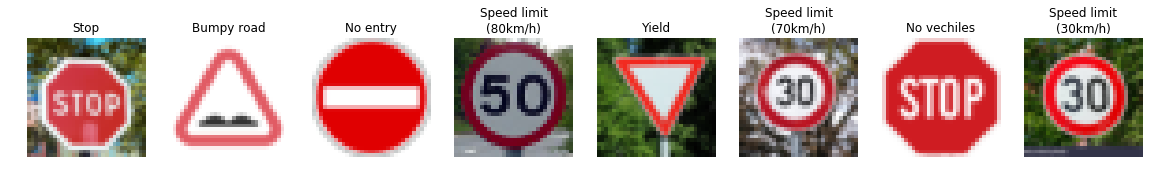

In [15]:
testOnOtherPictures('net.pth') # Testiranje (koriscenje) neuronske mreze na drugim slikama.

In [97]:
net = Net().to(device) # Instanciranje neuronske mreze.

criterion = nn.CrossEntropyLoss() # Instanciranje kriterijuma optimizacije, odnosno funkcije greske.

# Instanciranje optimizacionog algoritma. 
# U ovom slucaju adam.
# Optimizacioni algoritam optimizuje parametre neuronske mreze, odnosno tezine na ulazima neurona.
# Learning rate (korak ucenja) podesen je na 0.0001 kako bi se osigurala stabilna konvergencija.
optimizer = optim.Adam(net.parameters(), lr=0.0001)

epochs = 20 # Broj epoha za obucavanje.

train(net, criterion, optimizer, epochs) # Obucavanje neuronske mreze.

1. epoch. Loss: 1.921
2. epoch. Loss: 1.733
3. epoch. Loss: 1.347
4. epoch. Loss: 1.059
5. epoch. Loss: 0.862
6. epoch. Loss: 0.731
7. epoch. Loss: 0.635
8. epoch. Loss: 0.561
9. epoch. Loss: 0.505
10. epoch. Loss: 0.458
11. epoch. Loss: 0.419
12. epoch. Loss: 0.389
13. epoch. Loss: 0.360
14. epoch. Loss: 0.335
15. epoch. Loss: 0.313
16. epoch. Loss: 0.295
17. epoch. Loss: 0.277
18. epoch. Loss: 0.261
19. epoch. Loss: 0.247
20. epoch. Loss: 0.234
Finished Training


In [103]:
test() # Testiranje neuronske mreze.

Accuracy: 76.603%


In [99]:
torch.save(net, 'netAdam.pth') # Cuvanje obucene neuronske mreze.

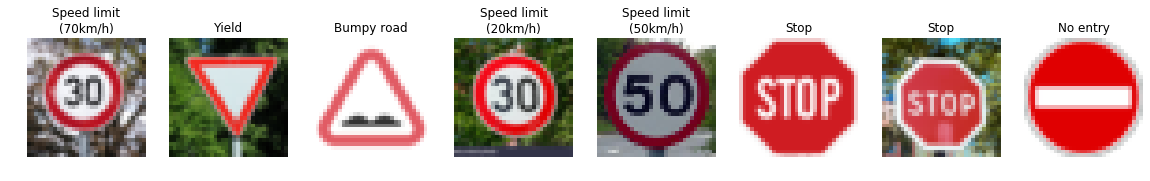

In [100]:
testOnOtherPictures('netAdam.pth') # Testiranje (koriscenje) neuronske mreze na drugim slikama.

In [17]:
# Neuronska mreza.
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x

In [18]:
net = TrafficSignNet().to(device) # Instanciranje neuronske mreze.

criterion = nn.CrossEntropyLoss() # Instanciranje kriterijuma optimizacije, odnosno funkcije greske.

# Instanciranje optimizacionog algoritma. 
# U ovom slucaju adam.
# Optimizacioni algoritam optimizuje parametre neuronske mreze, odnosno tezine na ulazima neurona.
# Learning rate (korak ucenja) podesen je na 0.0001 kako bi se osigurala stabilna konvergencija.
optimizer = optim.Adam(net.parameters(), lr=0.0001)

epochs = 20 # Broj epoha za obucavanje.

train(net, criterion, optimizer, epochs) # Obucavanje neuronske mreze.

1. epoch. Loss: 1.514
2. epoch. Loss: 0.939
3. epoch. Loss: 0.666
4. epoch. Loss: 0.492
5. epoch. Loss: 0.372
6. epoch. Loss: 0.289
7. epoch. Loss: 0.230
8. epoch. Loss: 0.188
9. epoch. Loss: 0.158
10. epoch. Loss: 0.136
11. epoch. Loss: 0.118
12. epoch. Loss: 0.107
13. epoch. Loss: 0.094
14. epoch. Loss: 0.085
15. epoch. Loss: 0.076
16. epoch. Loss: 0.070
17. epoch. Loss: 0.067
18. epoch. Loss: 0.061
19. epoch. Loss: 0.055
20. epoch. Loss: 0.053
Finished Training


In [19]:
test() # Testiranje neuronske mreze.

Accuracy: 90.325%


In [ ]:
torch.save(net, 'net2.pth') # Cuvanje obucene neuronske mreze.

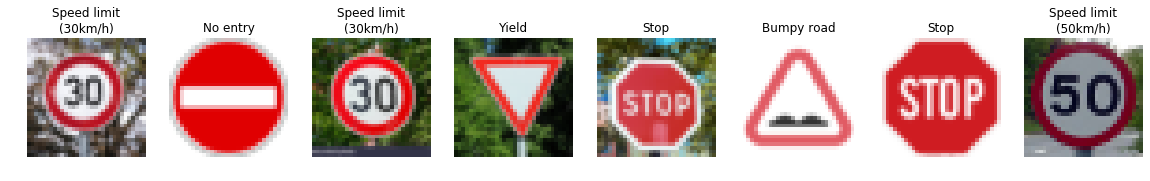

In [102]:
testOnOtherPictures('net2.pth') # Testiranje (koriscenje) neuronske mreze na drugim slikama.